In [25]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [26]:
#Loading MNIST Dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Scale the inputs in range of (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1

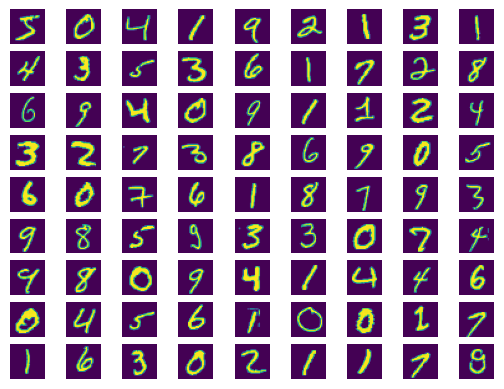

In [27]:
#Plot some example images from the training datasets
for i in range(81):
  plt.subplot(9, 9, i+1)
  plt.axis("off")
  #plot raw pixel data
  plt.imshow(x_train[i])
plt.show()

In [28]:
#Flattening 3D datasets to 2D datasets and converting the image size from 28*28 to 684
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [29]:
# Define the Generator Model
latent_dim = 100
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)
  model = Model(i, x)
  return model

In [30]:
#Define the Discriminator Model
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

In [31]:
# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile ( loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
# Build the generator
generator = build_generator(latent_dim)

In [32]:
## Create Noise Sample
z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False
fake_pred = discriminator(img)

In [33]:
#Create generator model
combined_model_gen = Model(z, fake_pred)
#Compile the combined model
combined_model_gen.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [34]:
#Define the parameters for training GANs
batch_size = 32
epochs = 12000
sample_period = 200
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)
#Store generator and discriminator loss in each epoch
g_losses = []
d_losses = []
#Create a file for generator to create and save images
if not os.path.exists('GAN_Images'):
  os.makedirs('GAN_Images')

In [35]:
#Create sample images
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)
  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5
  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):  #5*5 loop implies there will be 49 images on page
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("GAN_Images/%d.png" % epoch)
  plt.close()

In [36]:
#Train the discriminator followed by the generator to generate the images
for epoch in range(epochs):
  idx = np.random.randint(0, x_train.shape[0], batch_size) #Select a random batch of images
  real_imgs = x_train[idx]  #Train the discriminator

  noise = np.random.randn(batch_size, latent_dim)  #Generator for generating fake images
  fake_imgs = generator.predict(noise)
  # Train the discriminator
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)  #Both loss and accuracy are returned for the real images
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)  #Both loss and accuracy are returned for the fake images
  d_loss = 0.5 * (d_loss_real + d_loss_fake) #Average loss
  d_acc  = 0.5 * (d_acc_real + d_acc_fake) #Average accuracy

  #Train the generator
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)
  #Here we are attempting to fool the discriminator that generate images are real. Due to this reason, we are labeling it as 1.
  #Repeat the step!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)

  d_losses.append(d_loss)  #Save the loss at each epoch
  g_losses.append(g_loss)
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  if epoch % sample_period == 0:
    sample_images(epoch)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 16ms/step
epoch: 7101/12000, d_loss: 0.71, d_acc: 0.55, g_loss: 0.81
1/1 [==============================] - 0s 19ms/step
epoch: 7201/12000, d_loss: 0.70, d_acc: 0.45, g_loss: 0.77
1/1 [==============================] - 0s 16ms/step
epoch: 7301/12000, d_loss: 0.69, d_acc: 0.53, g_loss: 0.78
1/1 [==============================] - 0s 16ms/step
epoch: 7401/12000, d_loss: 0.71, d_acc: 0.42, g_loss: 0.78
1/1 [==============================] - 0s 17ms/step
epoch: 7501/12000, d_loss: 0.69, d_acc: 0.55, g_loss: 0.79
1/1 [==============================] - 0s 17ms/step
epoch: 7601/12000, d_loss: 0.68, d_acc: 0.59, g_loss: 0.76
1/1 [==============================] - 0s 21ms/step
epoch: 7701/12000, d_loss: 0.72, d_acc: 0.39, g_loss: 0.73
1/1 [==============================] - 0s 18ms/step
epoch: 7801/12000, d_loss: 0.70, d_acc: 0.52, g_loss: 0.74
1/1 [==============================] - 0s 15ms/step
epoch: 79

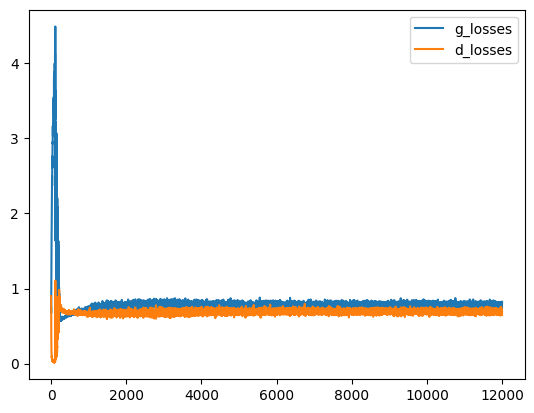

In [37]:
#Plot the loss function
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

**Observe the result**

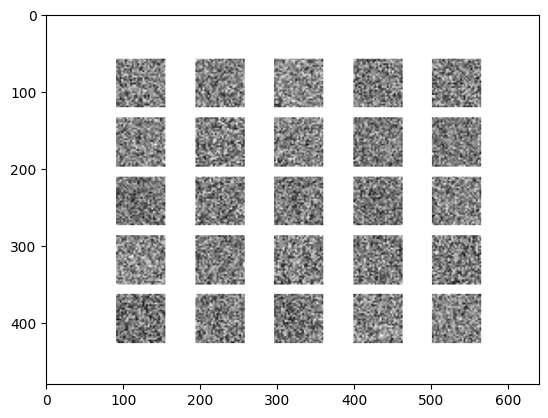

In [38]:
#Plot the generated image at 0 epoch
from skimage.io import imread
a = imread('GAN_Images/0.png')
plt.imshow(a)

**Observation:** There is no information that can be extracted from the generator, whereas the discriminator is capable enough to identify the fake case.

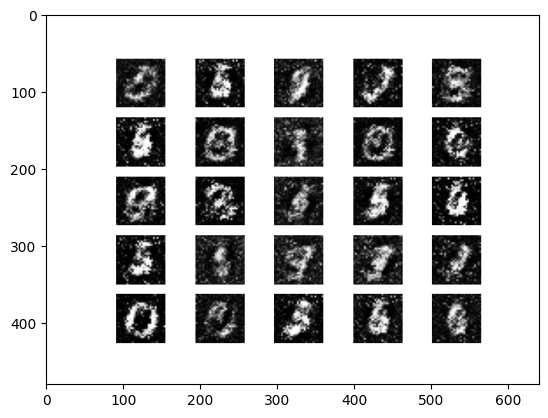

In [39]:
#Plot the generated image at 1000 epoch
from skimage.io import imread
a = imread('GAN_Images/1000.png')
plt.imshow(a)

**Observation:** The generator is gradually extracting some information. However, it is not good enough to fool the discriminator.

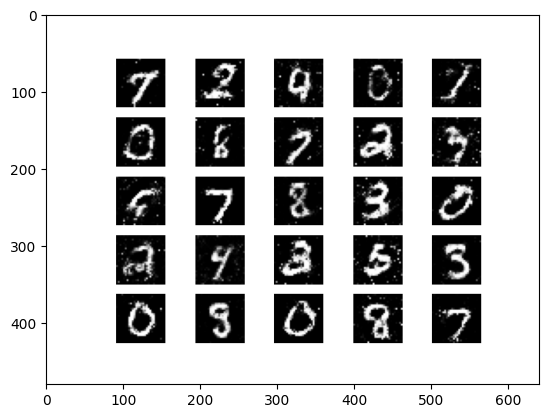

In [40]:
#Plot the generated image at 10000 epoch
from skimage.io import imread
a = imread('GAN_Images/10000.png')
plt.imshow(a)

**Observation:** Finally, the generator has built the images with the same qualities as the MNIST dataset, and there are healthy chances of making the discriminator fool.

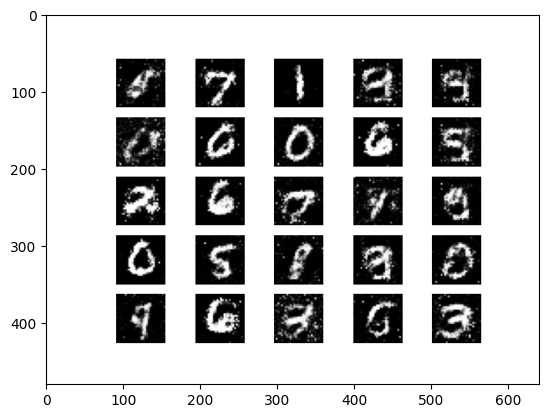

In [41]:
#Plot the generated image at 10000 epoch
from skimage.io import imread
a = imread('GAN_Images/4000.png')
plt.imshow(a)

Observation: The generator is gradually extracting some information. However, it is not good enough to fool the discriminator.